In [ ]:
%%capture
import os   ; import numpy as np    ; import pandas as pd   ; from scipy.interpolate import griddata    ; import matplotlib.pyplot as plt ; from matplotlib import patheffects 
import flopy    ; import flopy.utils.binaryfile as bf   ; from mfsetup import MF6model  ; from mfsetup.discretization import cellids_to_kij ; from gisutils import df2shp
import mfexport ; from mfexport.utils import get_water_table   # ; from pathlib import Path ; TA=Path("./TA");TA.mkdir(exist_ok=True)

m = MF6model.setup_from_yaml('pleasant_lgr_parent.yml')

#### Plot the inset and parent model grids with Lake Package connections by layer

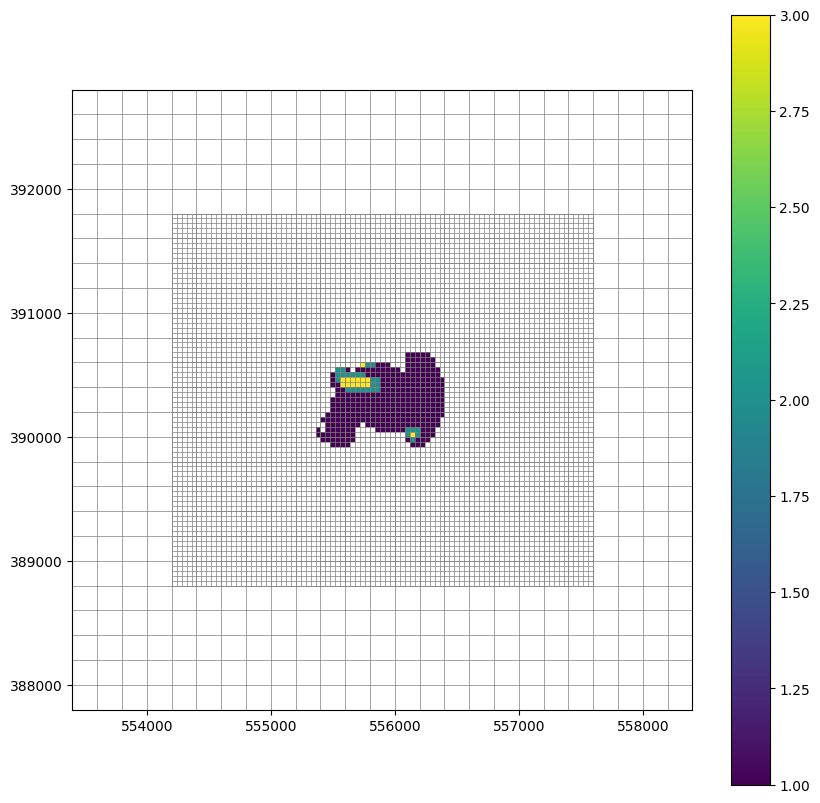

In [2]:
inset = m.inset['plsnt_lgr_inset']

l, r, b, t = m.modelgrid.extent
layer = 0

fig, ax = plt.subplots(figsize=(10, 10))
parent_mv = flopy.plot.PlotMapView(model=m, ax=ax, layer=layer)
inset_mv = flopy.plot.PlotMapView(model=inset, ax=ax, layer=layer)

vconn = inset.lak.connectiondata.array[inset.lak.connectiondata.array['claktype'] == 'vertical']
k, i, j = cellids_to_kij(vconn['cellid'])
lakeconnections = np.zeros((inset.nrow, inset.ncol))
lakeconnections[i, j] = np.array(k+1)
lakeconnections = np.ma.masked_array(lakeconnections, mask=lakeconnections == 0)
qmi = inset_mv.plot_array(lakeconnections)

#inset_mv.plot_bc('LAK', color='navy')
#parent_mv.plot_bc('WEL_0', color='red')

lcp = parent_mv.plot_grid(lw=0.5, ax=ax)
lci = inset_mv.plot_grid(lw=0.5)
ax.set_ylim(b, t)
ax.set_xlim(l, r)
ax.set_aspect(1)
plt.colorbar(qmi)

#### Make a cross section of the grid

(190.0, 400.0)

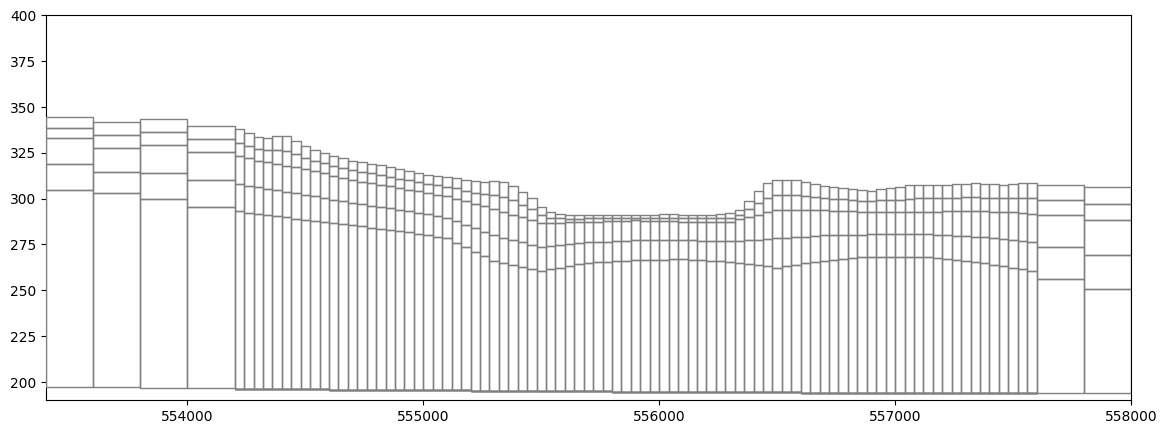

In [3]:
fig, ax = plt.subplots(figsize=(14, 5))
xs_line = [(553000, 390200), (558000, 390200)]
xs = flopy.plot.PlotCrossSection(model=m,
                                line={"line": xs_line}, ax=ax,
                                geographic_coords=True)
lc = xs.plot_grid(zorder=4)
xs2 = flopy.plot.PlotCrossSection(model=inset,
                                line={"line": xs_line}, ax=ax,
                                geographic_coords=True)
lc = xs2.plot_grid(zorder=4)
ax.set_ylim(190, 400)
#plt.savefig('../../docs/source/_static/pleasant_lgr_xsection.png', bbox_inches='tight')

### write the MODFLOW input files
(just like you would for a Flopy model)

In [4]:
m.write_input()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing package pleasant_lgr.gwfgwf...
  writing package pleasant_lgr.mvr...
  writing model plsnt_lgr_parent...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package rcha_0...
    writing package oc...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 269 based on size of stress_period_data
    writing package obs_0...
    writing package sfr_0...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 2 based on size of stress_period_data
    writing package obs_1...
    writing package obs_2...
  writing model plsnt_lgr_inset...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    

### Run the model

**Note:** Running the model through Flopy (as below) requires specification of the MODFLOW executable. In Flopy, the executable is specified via the ``exe_name`` argument to the simulation constructor for MODFLOW 6, or model constructor for previous MODFLOW versions. Similarly, in Modflow-setup, the ``exe_name`` is specified in the ``simulation:`` or ``model:`` block of the [configuration file](https://doi-usgs.github.io/modflow-setup/latest/config-file-gallery.html#pleasant-lake-test-case). This example assumes that a MODFLOW 6 executable with the name "mf6" either resides in the model workspace, or is included in the system path.

In [5]:
m.simulation.run_simulation()

FloPy is using the following executable to run the model: C:\Users\gross.DESKTOP-AIRQM2M\anaconda3\Scripts\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.1 02/10/2025

   MODFLOW 6 compiled Feb 14 2025 13:40:10 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither 

(True, [])

### Plot the head results

In [6]:
tmr_parent_headsobj = bf.HeadFile('../data/pleasant/pleasant.hds')
lgr_parent_headsobj = bf.HeadFile('plsnt_lgr_parent.hds')
lgr_inset_headsobj = bf.HeadFile('plsnt_lgr_inset.hds')

# read the head results for the last stress period
kper = 12
lgr_parent_hds = lgr_parent_headsobj.get_data(kstpkper=(0, kper))
lgr_inset_hds = lgr_inset_headsobj.get_data(kstpkper=(0, kper))

# Get the water table elevation from the 3D head results
inset_wt = get_water_table(lgr_inset_hds, nodata=1e30)
parent_wt = get_water_table(lgr_parent_hds, nodata=1e30)

# put in the lake level (not included in head output)
lake_results = pd.read_csv('lake1.obs.csv')
stage = lake_results['STAGE'][kper]
inset_wt[inset.lakarr[0] == 1] = stage

#### First combine the parent and inset model head results
(into a single grid at the inset model resolution; for a nicer looking plot)

In [7]:
# make the single grid
l, b, r, t = m.modelgrid.bounds
xi = np.arange(l, r, 40)
yi = np.arange(b, t, 40)[::-1]
Xi, Yi = np.meshgrid(xi, yi)

# make a single set of points
# including both parent and inset cell centers
# and water table values
x = m.modelgrid.xcellcenters[~parent_wt.mask]
y = m.modelgrid.ycellcenters[~parent_wt.mask]
x = np.append(x, inset.modelgrid.xcellcenters[~inset_wt.mask])
y = np.append(y, inset.modelgrid.ycellcenters[~inset_wt.mask])
z = parent_wt[~parent_wt.mask].data
z = np.append(z, inset_wt[~inset_wt.mask].data)

# interpolate the results from the points
# onto the single inset resolution grid
results = griddata((x, y), z, (Xi, Yi))

### Make the plot
* include the parent and inset model grids
* show the head contours for the combined parent/inset simulation
* show SFR boundary condition cells in green
* show the lakebed leakance zones

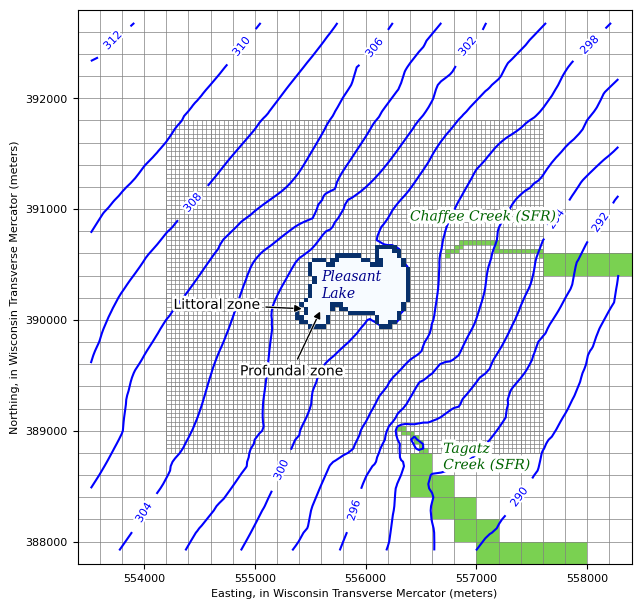

In [8]:
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

layer = 0
fig, ax = plt.subplots(figsize=(6.5, 6.5))
# create Flopy plot objects
parent_mv = flopy.plot.PlotMapView(model=m, ax=ax, layer=layer)
inset_mv = flopy.plot.PlotMapView(model=inset, ax=ax, layer=layer)

# plot boundary condition cells from Modflow-setup array properties
inset_bcs = np.ma.masked_array(inset._isbc2d, mask=inset._isbc2d==0)
parent_bcs = np.ma.masked_array(m._isbc2d, mask=m._isbc2d==0)
parent_mv.plot_array(parent_bcs, vmin=0, vmax=5)
inset_mv.plot_array(inset_bcs, vmin=0, vmax=5)

#bdlknc_values = inset.lak.connectiondata.array['bedleak']
conn = inset.lak.connectiondata.array
k, i, j = cellids_to_kij(conn['cellid'])
bdlknc = np.zeros((inset.nlay, inset.nrow, inset.ncol))
bdlknc[k, i, j] = conn['bedleak']
bdlknc = np.max(bdlknc, axis=0)
bdlknc = np.ma.masked_array(bdlknc, mask=bdlknc == 0)
inset_mv.plot_array(bdlknc, cmap='Blues', zorder=200)

# contour the combined inset/parent head results
levels = np.arange(290, 315, 2)
ctr = ax.contour(Xi, Yi, results, levels=levels, colors='b', zorder=10)
labels = ax.clabel(ctr, inline=True, fontsize=8, inline_spacing=10)
plt.setp(labels, path_effects=[
    patheffects.withStroke(linewidth=3, foreground="w")])

# plot the grid cell edges
lcp = parent_mv.plot_grid(lw=0.5, ax=ax)
lci = inset_mv.plot_grid(lw=0.5)

ax.set_ylim(b, t)
ax.set_xlim(l, r)
ax.set_aspect(1)
ax.set_ylabel('Northing, in Wisconsin Transverse Mercator (meters)')
ax.set_xlabel('Easting, in Wisconsin Transverse Mercator (meters)')

ax.text(555600, 390450, 'Pleasant\nLake', ha='left', va='top', color='DarkBlue', 
        fontsize=10, fontstyle='italic', family='Serif', zorder=202)
txt = ax.text(556400, 391000, 'Chaffee Creek (SFR)', ha='left', va='top', color='DarkGreen', 
        fontsize=10, fontstyle='italic', family='Serif', zorder=20)
txt.set_path_effects([patheffects.withStroke(linewidth=5, foreground='w')])
txt = ax.text(556700, 388900, 'Tagatz\nCreek (SFR)', ha='left', va='top', color='DarkGreen', 
        fontsize=10, fontstyle='italic', family='Serif', zorder=20)
txt.set_path_effects([patheffects.withStroke(linewidth=5, foreground='w')])

txt = ax.annotate("Littoral zone",
            xy=(555450, 390100), xycoords='data',
            xytext=(555050,390100), textcoords='data',
                  ha='right',
            arrowprops=dict(arrowstyle="-|>",
                            connectionstyle="arc3", fc='k'),
            path_effects=[patheffects.withStroke(linewidth=4, foreground='w')],
            zorder=203
            )
txt.arrow_patch.set_path_effects([
    patheffects.Stroke(linewidth=2, foreground="w"),
    patheffects.Normal()])

txt = ax.annotate("Profundal zone",
            xy=(555600, 390100), xycoords='data',
            xytext=(555800,389500), textcoords='data',
                  ha='right',
            arrowprops=dict(arrowstyle="-|>",
                            connectionstyle="arc3", fc='k'),
            path_effects=[patheffects.withStroke(linewidth=4, foreground='w')],
            zorder=203
            )
txt.arrow_patch.set_path_effects([
    patheffects.Stroke(linewidth=2, foreground="w"),
    patheffects.Normal()])

plt.tight_layout()
plt.savefig('postproc/pdfs/figure_2.pdf')

### Use [Modflow-export](https://github.com/aleaf/modflow-export) to export the modflow input to PDFs, rasters and shapefiles

In [9]:
for model in m, inset:
    mfexport.export(model, model.modelgrid, output_path=f'postproc/{model.name}/')

creating postproc\plsnt_lgr_parent\pdfs...
creating postproc\plsnt_lgr_parent\shps...
creating postproc\plsnt_lgr_parent\rasters...

dis package...
wrote postproc\plsnt_lgr_parent\rasters\thickness_lay0.tif
wrote postproc\plsnt_lgr_parent\rasters\thickness_lay1.tif
wrote postproc\plsnt_lgr_parent\rasters\thickness_lay2.tif
wrote postproc\plsnt_lgr_parent\rasters\thickness_lay3.tif
wrote postproc\plsnt_lgr_parent\rasters\thickness_lay4.tif
top:
wrote postproc\plsnt_lgr_parent\rasters\top.tif
botm:
wrote postproc\plsnt_lgr_parent\rasters\botm_lay0.tif
wrote postproc\plsnt_lgr_parent\rasters\botm_lay1.tif
wrote postproc\plsnt_lgr_parent\rasters\botm_lay2.tif
wrote postproc\plsnt_lgr_parent\rasters\botm_lay3.tif
wrote postproc\plsnt_lgr_parent\rasters\botm_lay4.tif
idomain:
wrote postproc\plsnt_lgr_parent\rasters\idomain_lay0.tif
wrote postproc\plsnt_lgr_parent\rasters\idomain_lay1.tif
wrote postproc\plsnt_lgr_parent\rasters\idomain_lay2.tif
wrote postproc\plsnt_lgr_parent\rasters\idomain_

#### Modflow-export can also create a summary table of the model inputs

In [10]:
for model in m, inset:
    mfexport.summarize(model, output_path=f'postproc/{model.name}/')

summarizing plsnt_lgr_parent input...
skipped, not implemented yet
skipped, not implemented yet
summarizing plsnt_lgr_inset input...
skipped, not implemented yet
